# File Info

Training for functions for neural odes. v1 contains training data segmented into pairs. This training failed. 

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [2]:
lc = ds.Hopf(rho=1.0, alpha=-1.0, beta=0.0)

In [4]:
a = torch.arange(-2.0, 2.0, 1.0); c = torch.ones_like(a)

r_vals = torch.arange(1, 5.0, 1.0)
ic = torch.cartesian_prod(a, a, r_vals)  #traj, dim




In [6]:
lc.gamma = 0.1
lc.f = lc.na_f

In [7]:
t_span = (0, 10); dt = 0.05
ic.shape #traj, dim

sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )

In [8]:
time = torch.arange(t_span[0], t_span[1], dt).unsqueeze(1).unsqueeze(2)  #(time, 1, 1)
time.shape

torch.Size([200, 1, 1])

In [ ]:
#time_expanded = time.repeat(1, ic.shape[0], 1)  #(time, traj, 1)
#time_expanded.shape

In [ ]:
#sol2 = torch.cat((sol, time_expanded), dim=-1)  #(time, traj, dim+1)
#sol.shape

In [9]:
data_tensor = torch.stack((sol[0:-4, :, :], sol[1:-3, :, :]), dim=1)

In [10]:
list = []
for i in range(data_tensor.shape[2]):
    list.append(data_tensor[:,:,i,:])

In [11]:
data_tensor = torch.concat(list, dim=0)

In [12]:

data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=64, shuffle=False)

In [13]:
data_loader.dataset.shape

torch.Size([12544, 2, 3])

In [ ]:
print(data_loader.dataset[:10,0, 0, 0 ]); print(data_loader.dataset[:10,1,0, 0]); 

IndexError: too many indices for tensor of dimension 3

# Model 

In [14]:
data_loader.dataset.shape

torch.Size([12544, 2, 3])

In [ ]:
model = nodes.NODE(input_dim=2, output_dim=2, hidden_dim=16, depth=8, activation_func=nn.Tanh(), t_span=(0, 0.05*(data_loader.dataset.shape[1]-1)), dt=0.01)

In [ ]:
nodes.Simple_FeedforwardNN(input_dim=2, depth=2, width=16, output_dim=2, activation_func=nn.Tanh())

Simple_FeedforwardNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [15]:
model = nodes.NODE2(input_dim=3, output_dim=3, hidden_dim=32, depth=4, activation_func=nn.Tanh())

In [16]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()



In [24]:
#index = ((dt/model.dt)*torch.arange(1, data_loader.dataset.shape[1], 1)).int()  -1#number of NODE steps to reach data time span~

In [25]:
data_loader.dataset.shape

torch.Size([18944, 2, 3])

In [27]:
model(t=0, x=data_loader.dataset[:,0,:])

tensor([[-0.5115,  0.2921, -0.1381],
        [-0.4979,  0.3263, -0.0818],
        [-0.4833,  0.3474, -0.0501],
        ...,
        [-0.4738,  0.3266,  0.4489],
        [-0.4906,  0.3443,  0.4394],
        [-0.5074,  0.3623,  0.4298]], grad_fn=<AddmmBackward0>)

In [17]:
t_eval = torch.arange(0, 0.1, dt)
t_eval

tensor([0.0000, 0.0500])

torch.Size([2, 4736, 2])

In [18]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss

tensor(0.0032, grad_fn=<MseLossBackward0>)

In [19]:
print(pred_x[-1, :, :].shape)
print(data_loader.dataset[:,1,:].shape)

torch.Size([12544, 3])
torch.Size([12544, 3])


In [20]:
torch.rk4()

AttributeError: module 'torch' has no attribute 'rk4'

In [21]:
# Longer as 20 backpropagations
num_epochs = 2000
#index = ((dt/model.dt)*torch.arange(1, data_loader.dataset.shape[1], 1)).int() -1 #number of NODE steps to reach data time span
for epoch in tqdm(range(num_epochs)):
    for i, (x_batch) in enumerate(data_loader): #(num_pairs, pairs, traj, dim)
        
        optimizer.zero_grad()

        # Predicting the trajectory
        pred_x = odeint(func=model, y0=x_batch[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
        loss = loss_fn(pred_x[-1, :, :, ], x_batch[:,1,:]) 
        loss
                

        # Backpropagation
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
        loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
        loss_list.append(loss.item())

  0%|          | 1/2000 [00:00<24:03,  1.38it/s]

Epoch 0, Loss: 0.00016223388956859708


  1%|          | 21/2000 [00:16<25:16,  1.30it/s]

Epoch 20, Loss: 2.4417624445050023e-05


  2%|▏         | 41/2000 [00:30<23:14,  1.40it/s]

Epoch 40, Loss: 1.3936841241957154e-05


  3%|▎         | 61/2000 [00:45<23:10,  1.39it/s]

Epoch 60, Loss: 6.996931915637106e-06


  4%|▍         | 81/2000 [01:00<23:13,  1.38it/s]

Epoch 80, Loss: 1.9556027837097645e-05


  5%|▌         | 101/2000 [01:14<22:46,  1.39it/s]

Epoch 100, Loss: 1.9385177438380197e-05


  6%|▌         | 121/2000 [01:29<22:57,  1.36it/s]

Epoch 120, Loss: 1.781305400072597e-05


  7%|▋         | 141/2000 [01:44<24:46,  1.25it/s]

Epoch 140, Loss: 1.5444793461938389e-06


  8%|▊         | 161/2000 [01:59<22:17,  1.37it/s]

Epoch 160, Loss: 1.952511775016319e-05


  9%|▉         | 181/2000 [02:14<21:48,  1.39it/s]

Epoch 180, Loss: 1.6010843637559447e-06


 10%|█         | 201/2000 [02:29<25:31,  1.17it/s]

Epoch 200, Loss: 8.44177611725172e-06


 10%|█         | 205/2000 [02:33<22:24,  1.34it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Epochs')

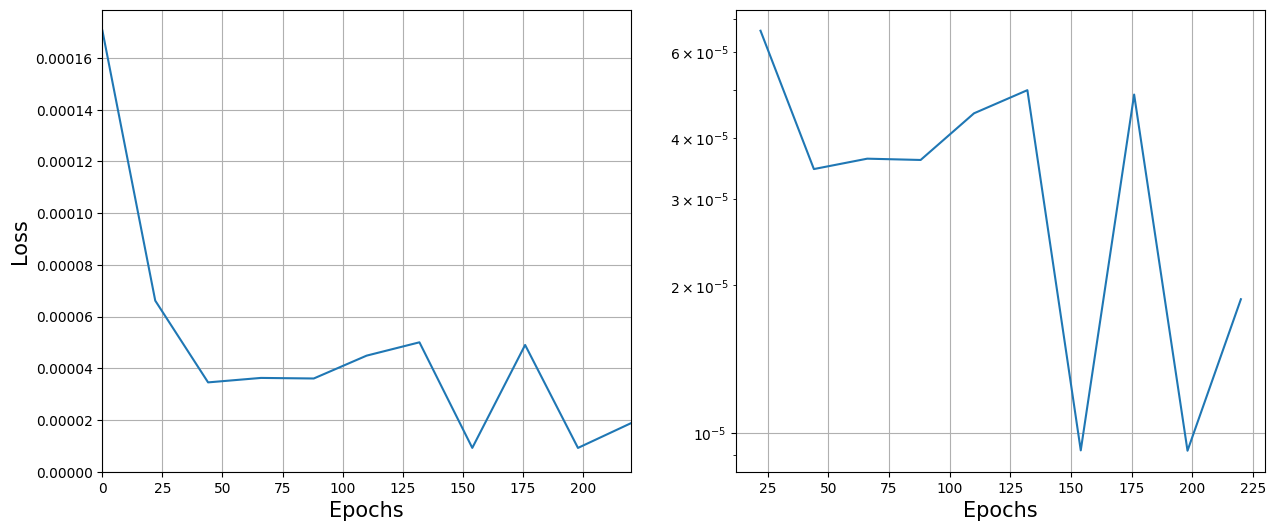

In [22]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs*20, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs*20)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs*20, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [23]:
pred_x.shape

torch.Size([2, 64, 3])

In [24]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss_list.append(loss.item())
print(f'Final Loss: {loss.item()}')

Final Loss: 1.4195357834978495e-05


# Analyzing the trained model

In [25]:
def trained_f(t, x):
    #t_tensor = torch.tensor([t]).expand(x.shape[0], 1)
    #input = torch.cat((x, t_tensor), dim=-1)

    z = model.input_layer(x)

    out = model.f(t, z)
    return model.output_layer(out)

## Data Generation with trained NODE

In [30]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  
c = torch.arange(-1, 8.0, 0.1)

pts = torch.cartesian_prod(a, b, c)  # (num_pts, dim)
pts.shape
t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

In [31]:
pts.shape

torch.Size([9000, 3])

In [32]:


node_data = odeint(func=model, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})


node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(400, 9000, 3)
(400, 9000, 3)


## Plotting phase space

In [33]:
pts

tensor([[-2.0000, -2.0000, -1.0000],
        [-2.0000, -2.0000, -0.9000],
        [-2.0000, -2.0000, -0.8000],
        ...,
        [ 2.0000,  2.0000,  7.7000],
        [ 2.0000,  2.0000,  7.8000],
        [ 2.0000,  2.0000,  7.9000]])

In [34]:
pts[:, 2] == 2.0

tensor([False, False, False,  ..., False, False, False])

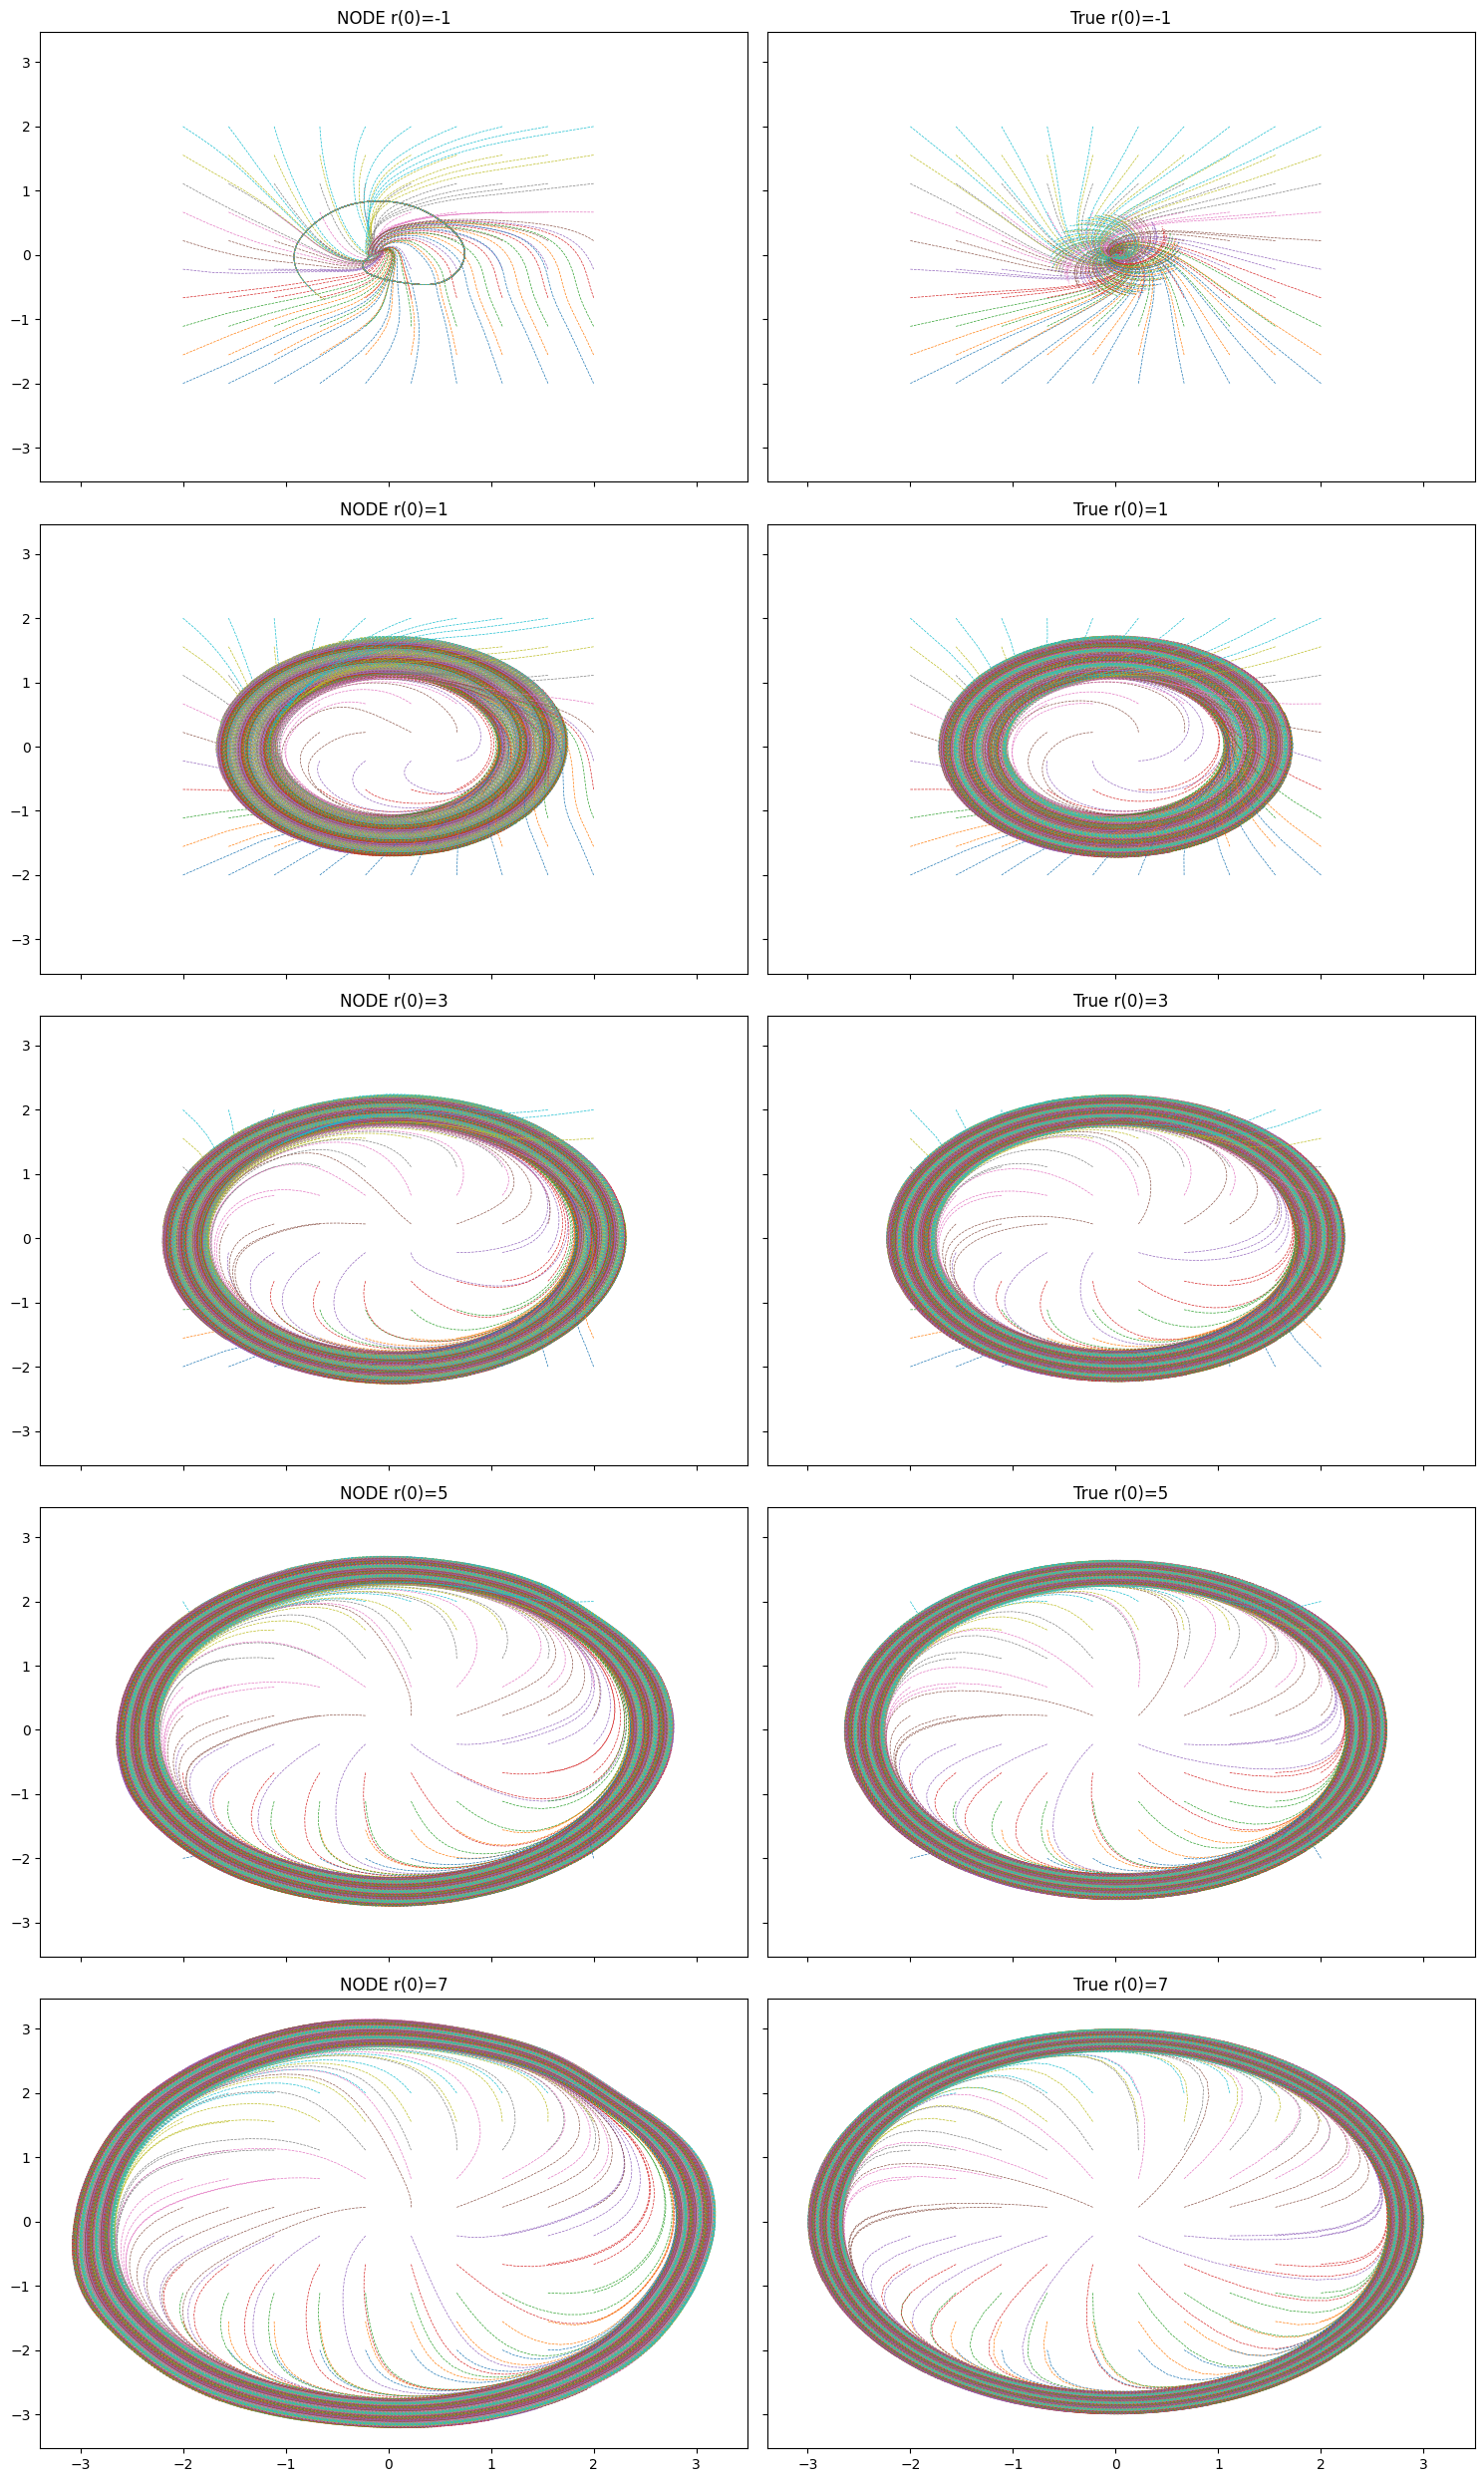

In [35]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0],
                    node_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0],
                    true_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'X')

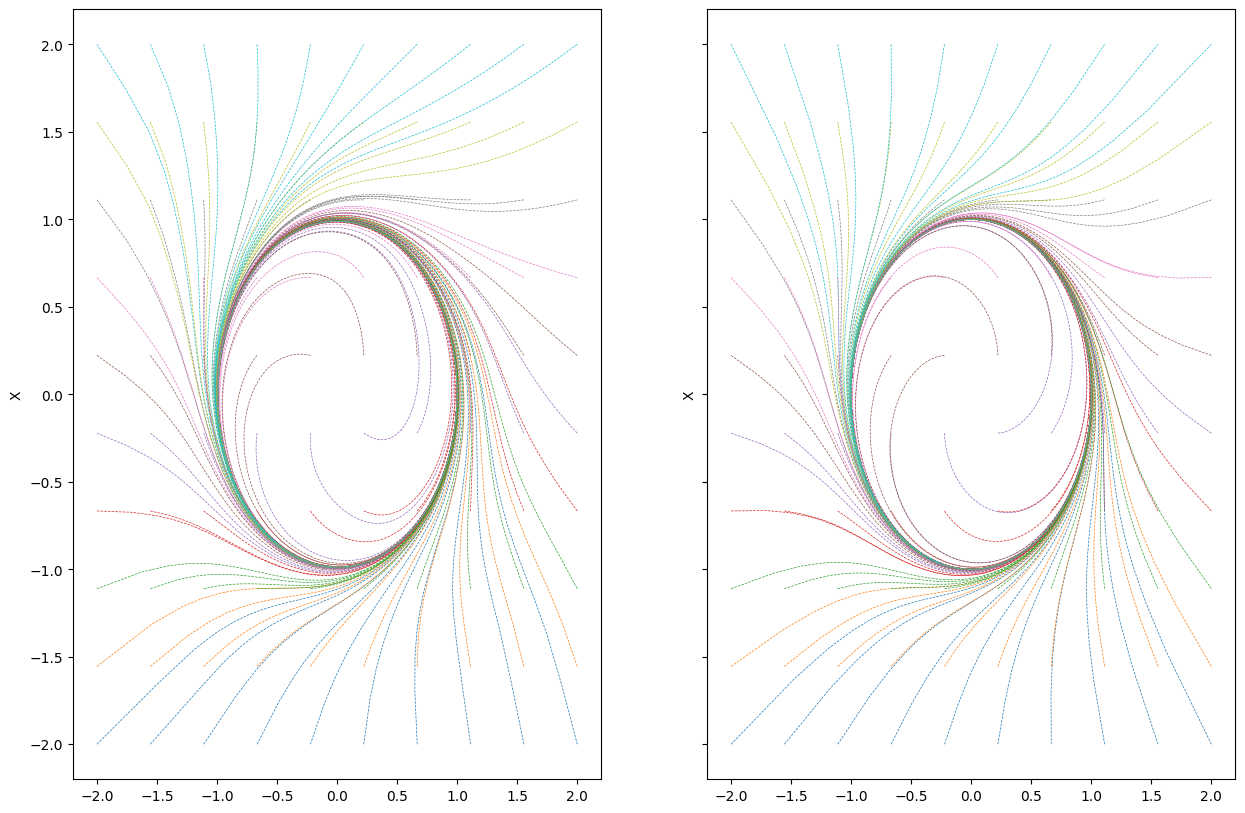

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].plot(node_data[:, :, 0],
                node_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_ylabel('X')


axes[1].plot(true_data[:, :, 0],
                true_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].set_ylabel('X')

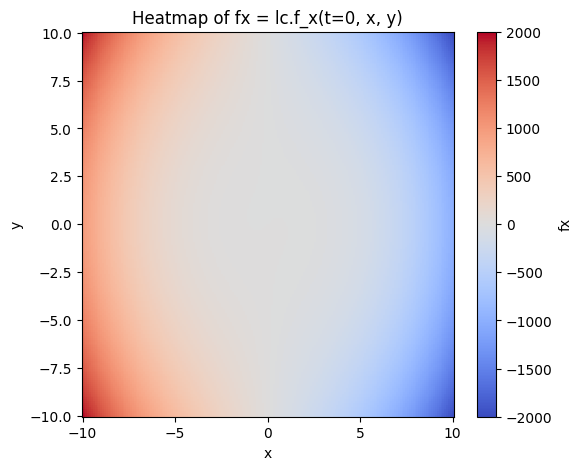

In [139]:
# Evaluate lc.f on a 2D grid (t = 0)
x_min, x_max, y_min, y_max = -10.0, 10.0, -10.0, 10.0
n = 200
xs = torch.linspace(x_min, x_max, n)
ys = torch.linspace(y_min, y_max, n)
X, Y = torch.meshgrid(xs, ys, indexing="ij")

pts = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)  # (N, 2)
t0 = torch.zeros(pts.shape[0])

with torch.no_grad():
    f_grid = lc.f(t0, pts)  # (N, 2)
    fx = f_grid[:, 0].reshape(n, n)
    fy = f_grid[:, 1].reshape(n, n)

# Example: plot fx (no absolute value)
plt.figure(figsize=(6, 5))
plt.pcolormesh(X.numpy(), Y.numpy(), fx.numpy(), shading="auto", norm=colors.CenteredNorm(), cmap=cm.coolwarm)
plt.colorbar(label="fx")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heatmap of fx = lc.f_x(t=0, x, y)")
plt.show()

In [ ]:
# Plotting time traces: 

In [36]:
traj = 50
t = t_eval_pred.detach().numpy()
x = node_data[:, traj, :]
x_true = true_data[:, traj, :]



In [37]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [38]:

r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])

C:\Users\jackr\AppData\Local\Temp\ipykernel_30848\3089097437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


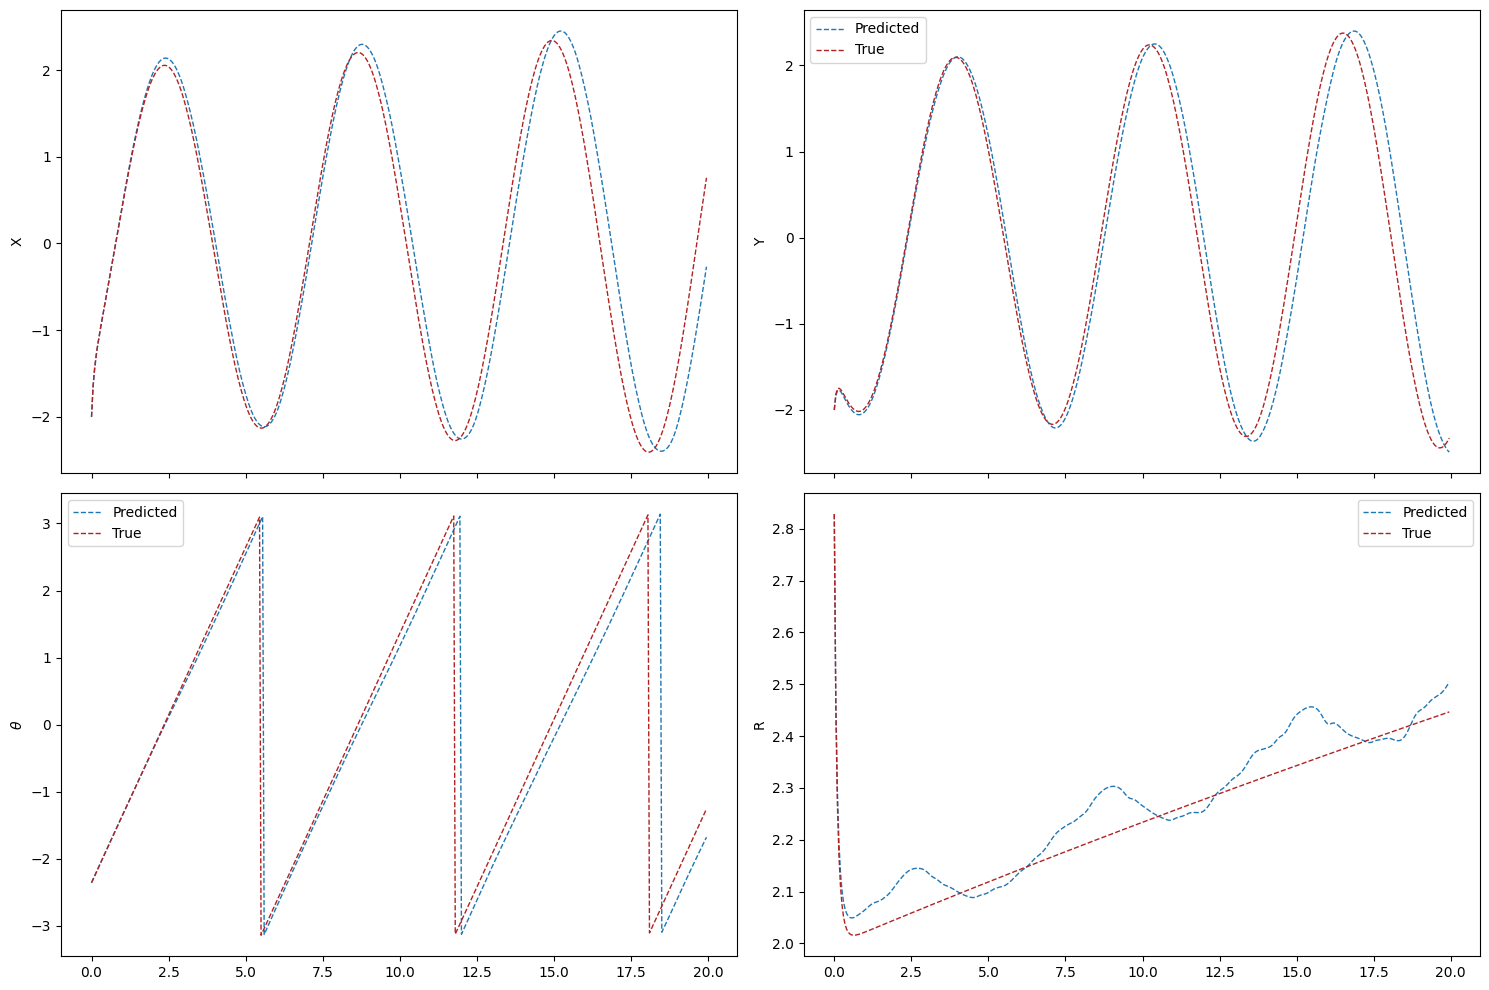

In [39]:


fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 1].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()